In [1]:
import csv
import os
import pandas as pd
import collections
import ast
import time
import collections
import json
import sqlite3
import xxhash
import numpy as np
import pickle 
import random
import glob
from io import StringIO
from pathlib import Path
from openai import OpenAI, AsyncOpenAI
import openai
print(openai.__version__)
os.environ["OPENAI_API_KEY"] =

openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key=os.getenv("OPENAI_API_KEY"),
)

1.90.0


In [2]:
from prompts.all_prompts import *
from order_by.sorting import *
from order_by.utils import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
def sortedness(gold_list, sorted_data):
    kendalltau = kendalltau_distance(gold_list[:], sorted_data[:])
    return kendalltau

def store_metadata(d, sorted_data, kendalltau, api_calls, tokens, memory_size = 0):
    if memory_size == 0:
        d['sorted_data'] = sorted_data
        d['kendalltau'] = kendalltau
        d['api_calls'] = api_calls
        d['tokens'] = tokens
    else:
        d[memory_size] = {}
        d[memory_size]['sorted_data'] = sorted_data
        d[memory_size]['kendalltau'] = kendalltau
        d[memory_size]['api_calls'] = api_calls
        d[memory_size]['tokens'] = tokens
        
        
    
async def experiment(dataname, sort_by_columns, column_to_compare, log_filename, pointwise_prompt_template,\
               external_pointwise_prompt_template, external_comparison_prompt_template,\
               pairwise_comparison_prompt_template, tolerance = 0.01, out_t = float):
    random.seed(0)
    
    fname = f"{dataname}.csv"
    file_path = f"./data/{fname}"
    data = pd.read_csv(file_path)

    sorted_df = data.sort_values(by=sort_by_columns, ascending=[True, True])

    print(sorted_df.head(10))
    print(len(sorted_df))
    
    gold_list = data[column_to_compare].tolist()
    shuffled_list = random.sample(gold_list, len(gold_list)) # shuffle the sorted list

    results = {}
    # "gpt-5-2025-08-07" too expensive
    for modelname in ["gpt-4o", "gpt-4o-mini"]:
        results[modelname] = {'pointwise_sort':{}, 'quick_sort':{}, 'quick_sort_3':{}, 'heap_sort':{},\
                              'external_pointwise_sort':{}, 'external_bubble_sort':{},\
                              'external_merge_sort':{}, 'hybrid_sort_3':{}, 'quick_sort_5':{}}
        memory_sizes = [16]
        if modelname == 'gpt-4o-mini':
            memory_sizes = [4, 8]
        print(modelname)
        
        sorted_data, num_api_calls, tokens, confidences = await pointwise_sort(shuffled_list, client, pointwise_prompt_template, modelname, out_t)
        kendalltau = sortedness(gold_list, sorted_data)
        print("pointwise_sort")
        print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}.\n {confidences}")
        store_metadata(results[modelname]['pointwise_sort'], sorted_data, kendalltau, num_api_calls, tokens)

        sorted_data, num_api_calls, tokens = await quick_sort(shuffled_list, client, pairwise_comparison_prompt_template, modelname, False, 1)
        kendalltau = sortedness(gold_list, sorted_data)
        print("quick_sort")
        print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}.\n")
        store_metadata(results[modelname]['quick_sort'], sorted_data, kendalltau, num_api_calls, tokens)

        votes = 3
        sorted_data, num_api_calls, tokens = await quick_sort(shuffled_list, client, pairwise_comparison_prompt_template, modelname, False, votes)
        kendalltau = sortedness(gold_list, sorted_data)
        print(f"quick_sort with vote={votes}")
        print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}.")
        store_metadata(results[modelname]['quick_sort_3'], sorted_data, kendalltau, num_api_calls, tokens)


        sorted_data, num_api_calls, tokens, confidences = await external_pointwise_sort(shuffled_list, external_values, client, external_pointwise_prompt_template, modelname, out_t, tolerance)
        kendalltau = sortedness(gold_list, sorted_data)
        print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}.\n {confidences}")
        store_metadata(results[modelname]['external_pointwise_sort'], sorted_data, kendalltau, num_api_calls, tokens)
            
        votes = 3
        sorted_data, num_api_calls, tokens = await hybrid_sort(shuffled_list, external_values, votes, client, external_pointwise_prompt_template, pairwise_comparison_prompt_template, modelname, out_t)
        kendalltau = sortedness(gold_list, sorted_data)
        print(f"hybrid_sort 3")
        print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}.\n")
        store_metadata(results[modelname]['hybrid_sort_3'], sorted_data, kendalltau, num_api_calls, tokens)
            
    
        for m in memory_sizes:
            sorted_data, num_api_calls, tokens = await external_bubble_sort(shuffled_list, external_comparisons, m, client, external_comparison_prompt_template, modelname)
            print(f"external_bubble_sort sorted data length {len(sorted_data)}")
            kendalltau = sortedness(gold_list, sorted_data)
            print(f"external_bubble_sort {m}")
            print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}\n")
            store_metadata(results[modelname]['external_bubble_sort'], sorted_data, kendalltau, num_api_calls, tokens, m)


            sorted_data, num_api_calls, tokens = await external_merge_sort(shuffled_list, external_comparisons, m, client, external_comparison_prompt_template, modelname)
            print(f"external_merge_sort sorted data length {len(sorted_data)}")
            kendalltau = sortedness(gold_list, sorted_data)
            print(f"external_merge_sort {m}")
            print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}.\n")
            store_metadata(results[modelname]['external_merge_sort'], sorted_data, kendalltau, num_api_calls, tokens, m)


In [5]:
dataname = "nba_heights_200"
column_to_sort = "full_name"
log_filename = "./logs/nba_heights.json"
await experiment(
         dataname,
        ["h_meters", "full_name"],
        "full_name",
        log_filename,
        nba_pointwise_prompt_template,
        nba_external_pointwise_prompt_template, 
        nba_external_comparison_prompt_template,
        nba_pairwise_comparison_prompt_template,
        0.01,
        float
    )

           full_name  h_meters
6       Paul Millsap      2.01
47        Jeff Green      2.03
94        Kevin Love      2.03
0   Luc Mbah a Moute      2.03
1        Luke Walton      2.03
3        Mike Miller      2.03
4      Nicolas Batum      2.03
5     Othello Hunter      2.03
7       Reggie Evans      2.03
8    Renaldo Balkman      2.03
200
gpt-4o
pointwise_sort
kendalltau score: 0.9249246231155779, api calls: 0, tokens: 73550.
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [20]:
async def experiment(dataname, sort_by_columns, column_to_compare, log_filename, pointwise_prompt_template,\
               external_pointwise_prompt_template, external_comparison_prompt_template,\
               pairwise_comparison_prompt_template, tolerance = 0.01, out_t = float):
    random.seed(0)
    
    fname = f"{dataname}.csv"
    file_path = f"./data/{fname}"
    data = pd.read_csv(file_path)

    sorted_df = data.sort_values(by=sort_by_columns, ascending=[True, True])

    print(sorted_df.head(10))
    print(len(sorted_df))
    
    gold_list = data[column_to_compare].tolist()
    shuffled_list = random.sample(gold_list, len(gold_list)) # shuffle the sorted list

    results = {}
    # "gpt-5-2025-08-07" too expensive
    for modelname in ["gpt-4o"]:
        results[modelname] = {'pointwise_sort':{}, 'quick_sort':{}, 'quick_sort_3':{}, 'heap_sort':{},\
                              'external_pointwise_sort':{}, 'external_bubble_sort':{},\
                              'external_merge_sort':{}, 'hybrid_sort_3':{}, 'quick_sort_5':{}}
        memory_sizes = [8]
        if modelname == 'gpt-4o-mini':
            memory_sizes = [4, 8]
        print(modelname)
        
    
        for m in memory_sizes:
            sorted_data, num_api_calls, tokens = await external_bubble_sort(shuffled_list, external_comparisons, m, client, external_comparison_prompt_template, modelname)
            print(f"external_bubble_sort sorted data length {len(sorted_data)}")
            kendalltau = sortedness(gold_list, sorted_data)
            print(f"external_bubble_sort {m}")
            print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}\n")
            store_metadata(results[modelname]['external_bubble_sort'], sorted_data, kendalltau, num_api_calls, tokens, m)


            sorted_data, num_api_calls, tokens = await external_merge_sort(shuffled_list, external_comparisons, m, client, external_comparison_prompt_template, modelname)
            print(f"external_merge_sort sorted data length {len(sorted_data)}")
            kendalltau = sortedness(gold_list, sorted_data)
            print(f"external_merge_sort {m}")
            print(f"kendalltau score: {kendalltau}, api calls: {num_api_calls}, tokens: {tokens}.\n")
            store_metadata(results[modelname]['external_merge_sort'], sorted_data, kendalltau, num_api_calls, tokens, m)

dataname = "nba_heights_200"
column_to_sort = "full_name"
log_filename = "./logs/nba_heights_4o.json"
await experiment(
         dataname,
        ["h_meters", "full_name"],
        "full_name",
        log_filename,
        nba_pointwise_prompt_template,
        nba_external_pointwise_prompt_template, 
        nba_external_comparison_prompt_template,
        nba_pairwise_comparison_prompt_template,
        0.01,
        float
    )

           full_name  h_meters
6       Paul Millsap      2.01
47        Jeff Green      2.03
94        Kevin Love      2.03
0   Luc Mbah a Moute      2.03
1        Luke Walton      2.03
3        Mike Miller      2.03
4      Nicolas Batum      2.03
5     Othello Hunter      2.03
7       Reggie Evans      2.03
8    Renaldo Balkman      2.03
200
gpt-4o
external_bubble_sort sorted data length 200
external_bubble_sort 8
kendalltau score: 0.9138693467336684, api calls: 1275, tokens: 559261

external_merge_sort sorted data length 200
external_merge_sort 8
kendalltau score: 0.8797989949748743, api calls: 169, tokens: 74701.



Fitted parameters:
A = 0.0529
B = 0.5144
x0 = 0.0000


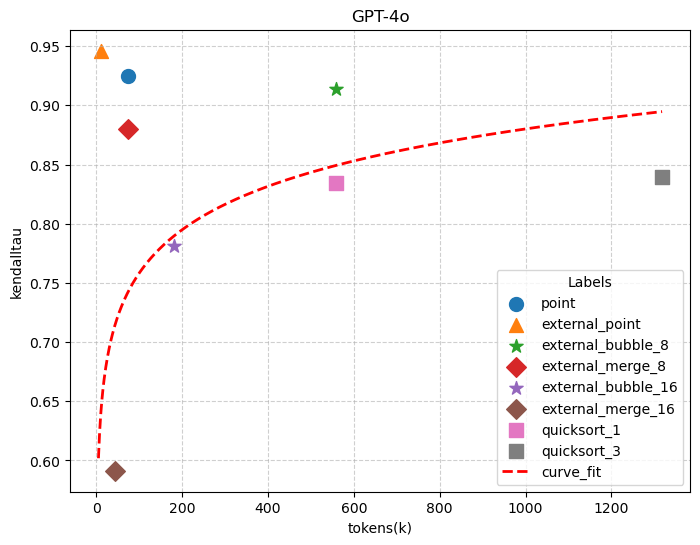

In [65]:
from scipy.optimize import curve_fit
# hybrid 0.9428140703517588 92608

kendalltau = [0.924924, 0.9461306532663316, 
              0.9138693467336684, 0.8797989949748743,
              0.7808040201005024,0.5913567839195979,
              0.8346733668341708, 0.8390954773869347
             ]
tokens = [73550, 11423,
          559261, 74701,
          181349, 43221,
          559220, 1317858
         ]
tokens = [t/1000.0 for t in tokens]
dot_labels = ["point", "external_point",\
              "external_bubble_8", "external_merge_8",\
              "external_bubble_16", "external_merge_16",\
              "quicksort_1", "quicksort_3"
             ]
markers = ['o', '^',\
           '*', 'D',
           '*', 'D',
           's', 's'
          ] 


            
# Create scatter plot
plt.figure(figsize=(8, 6))

for x, y, label, m in zip(tokens, kendalltau, dot_labels, markers):
    plt.scatter(x, y, s=100, marker=m, label=label)



    
def log_linear(x, A, B, x0):
    return A * np.log(x + x0) + B

y_points = kendalltau[2:]
x_points = tokens[2:]


x_points = np.array(x_points, dtype=float)
y_points = np.array(y_points, dtype=float)
# Initial guess and bounds (ensure x + x0 > 0 ⇒ x0 > -min(x); we keep x0 >= 1e-8)
p0 = [y_points.ptp(), y_points.min(), 0.1]
bounds = ([-np.inf, -np.inf, 1e-8], [np.inf, np.inf, np.inf])

popt, pcov = curve_fit(log_linear, x_points, y_points, p0=p0, bounds=bounds, maxfev=50000)
A, B, x0 = popt

# R^2
y_hat = log_linear(x_points, *popt)
ss_res = np.sum((y_points - y_hat)**2)
ss_tot = np.sum((y_points - y_points.mean())**2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# Smooth curve for plotting
x_fit = np.linspace(x_points.min()-38, x_points.max(), 1000)
y_fit = log_linear(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label="curve_fit")


print("Fitted parameters:")
print(f"A = {A:.4f}")
print(f"B = {B:.4f}")
print(f"x0 = {x0:.4f}")
    

plt.legend(title="Labels")


# Axis labels and title
plt.xlabel("tokens(k)")
plt.ylabel("kendalltau")
plt.title("GPT-4o")

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Fitted parameters:
A = 0.0529
B = 0.5144
x0 = 0.0000


/var/folders/7g/jht_lgvx2113j5symxv_cvj80000gn/T/ipykernel_86017/2210407922.py:32: RuntimeWarning: invalid value encountered in log
  return A * np.log(x + x0) + B


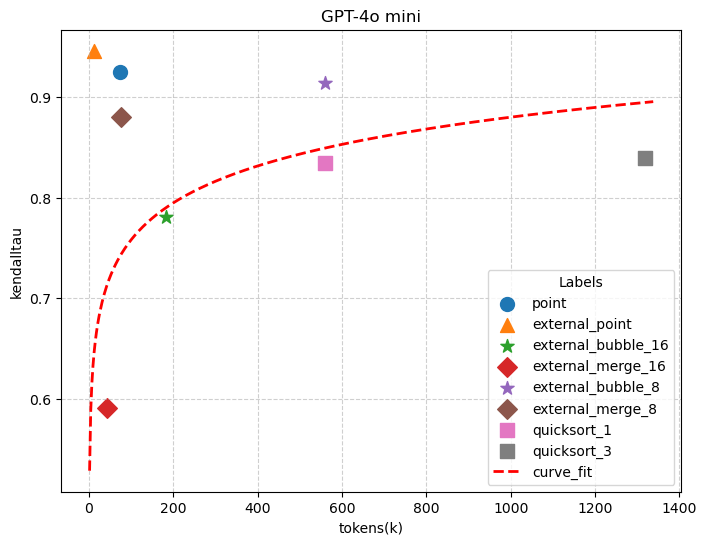

In [62]:
kendalltau = [0.7159798994974873, 0.6156783919597989,\
              0.7123618090452262, 0.6281407035175879,\
              0.6500502512562814,0.17206030150753768,\
              0.5989949748743718, 0.5181909547738693,\
             ]
tokens = [65391, 22243, 1906049, 158000,
          529852, 77629,\
         620831, 1396997,\
         ]
tokens = [t/1000.0 for t in tokens]
dot_labels = ["point", "external_point",\
              "external_bubble_4", "external_merge_4",
              "external_bubble_8", "external_merge_8",
              "quicksort_1", "quicksort_3",\
             ]
markers = ['o', '^', '*', 'D',\
           "*", "D",\
           's', 's'
          ] 


# Create scatter plot
plt.figure(figsize=(8, 6))

for x, y, label, m in zip(tokens, kendalltau, dot_labels, markers):
    plt.scatter(x, y, s=100, marker=m, label=label)



    
def log_linear(x, A, B, x0):
    return A * np.log(x + x0) + B

y_points = kendalltau[2:]
x_points = tokens[2:]

x_points = np.array(x_points, dtype=float)
y_points = np.array(y_points, dtype=float)
# Initial guess and bounds (ensure x + x0 > 0 ⇒ x0 > -min(x); we keep x0 >= 1e-8)
p0 = [y_points.ptp(), y_points.min(), 0.1]
bounds = ([-np.inf, -np.inf, 1e-8], [np.inf, np.inf, np.inf])

popt, pcov = curve_fit(log_linear, x_points, y_points, p0=p0, bounds=bounds, maxfev=80000)
A, B, x0 = popt

# R^2
y_hat = log_linear(x_points, *popt)
ss_res = np.sum((y_points - y_hat)**2)
ss_tot = np.sum((y_points - y_points.mean())**2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# Smooth curve for plotting
x_fit = np.linspace(x_points.min()-50, x_points.max()+20, 500)
y_fit = log_linear(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, label="curve_fit")

print("Fitted parameters:")
print(f"A = {A:.4f}")
print(f"B = {B:.4f}")
print(f"x0 = {x0:.4f}")

    

plt.legend(title="Labels")


# Axis labels and title
plt.xlabel("tokens(k)")
plt.ylabel("kendalltau")
plt.title("GPT-4o mini")

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()